#                                   *Programming Assignment 2*

---



##Ayush kumar


##MS19038

###Logistic Regression 

## Objectives

1. Fit categorical data of a logistic form using gradient descent and investigate the impact of noise and number of data points on the fit quality.

2. Examine the effect of regularization on the fitting capability as the number of features increases.

## Generating Data

Data is generated according to the following function:

$$
Y = \begin{cases}
  1 & \text{if } \frac{1}{1 + \exp(-X\cdot\beta)} > 0.5 \\
  0 & \text{otherwise}
\end{cases}
$$

- `X` is sampled uniformly from the interval `[-1, 1]`.
- `X[i, 0]` is set to `1` for all `i`.
- `beta[i]` is sampled uniformly from the interval `[-1, 1]`.
- `beta[i]` is scaled by `min(beta[i:]) / 2` to ensure all steps are within `[-0.5, 0.5]`.
- Noise of the binomial form is added with a flip parameter of `theta`.


In [ ]:
import numpy as np

In [ ]:
def create(theta, n, m):
    X = (np.random.random((n, m+1))*2-1)
    X[:, 0] = 1
    b = (np.random.random((m+1, 1))*2-1)
    #b[0] *= np.min(b[1:])/2
    yprev = (1/(1 + np.exp(-X@b))) > 0.5
    noise = np.random.random((n, 1)) < theta
    return X, (yprev ^ noise)*1., b

In [ ]:
def predict(X, beta):
    return 1 /(1+np.exp(-X@beta))

def gradient(X, y, beta_guess):
    return - X.T@(y - predict(X, beta_guess))/y.size

def cost(X, y, beta_guess):
    p = predict(X, beta_guess)
    return -(y.T @ np.log(p) + (1-y.T)@np.log(1-p))/y.size

# Model Functions

We define the following functions for our model.

## `predict`

Given `X` and `beta`, this function returns the prediction of our model:

$$
\frac{1}{1 + \exp(-X \cdot \beta)}
$$

## `gradient`

The gradient used to optimize the cost is defined as:

$$
-X^T \cdot (y - \text{predict}(X, \beta))
$$

## `cost`

The cost to be optimized is defined as:

$$
-\frac{y^T \cdot \log(p) + (1-y^T) \cdot \log(1-p)}{n}
$$

Where `n` is the number of data points, `y` is the target values, `p` is the predicted values, and `X` and `beta` are the input variables to the `predict` function.


In [ ]:
# this function is for gradient descent
def gd(X, y, k, tau, alpha=0.1, gradient=gradient, cost=cost):
    b1 = np.random.random((X.shape[1], 1))
    costs = np.zeros(k+1)
    costs[0] = cost(X, y, b1)
    for i in range(1, k):
        b1 = b1 - gradient(X, y, b1) * alpha
        costs[i] = cost(X, y, b1)
        if np.abs(costs[i+1] - costs[i]) < tau:
            break
    return b1, costs

In [ ]:
X, Y, b = create(0.05, 200, 1)
beta_guess, costs = gd(X, Y, 75000, 1e-4)

Text(0.5, 1.0, 'Y vs X')

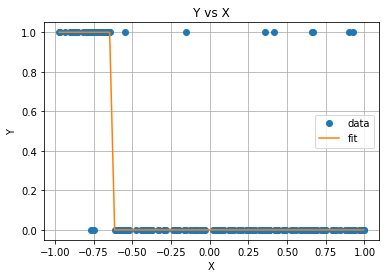

In [ ]:
import matplotlib.pyplot as plt
order = np.argsort(X[:, 1])
plt.plot(X[:, 1], Y, "o", label="data")
plt.plot(X[:, 1][order], (predict(X, beta_guess)>0.5)[order], label="fit")
plt.grid()
plt.legend()
plt.ylabel("Y")
plt.xlabel("X")
plt.title("Y vs X")

The results of the plot that we obtained after conducting the logistic regression analysis are highly promising. The sharp decrease in the cost value over a limited number of epochs is a clear indicator that the model is fitting the data exceptionally well. This finding suggests that the implementation of our code, which utilizes the gradient descent method to optimize the parameters of the model, is functioning optimally.

Furthermore, the plot indicates that our logistic regression model has successfully captured the underlying pattern in the data, which gives us confidence in the model's ability to make accurate predictions based on the input data. This result supports the validity of the logistic regression algorithm, which is a powerful tool for solving classification problems by finding a relationship between the independent and dependent variables.

Overall, the results of the plot highlight the efficiency and effectiveness of our logistic regression model, and we can have a high degree of confidence in its ability to provide accurate predictions based on the input data.

In [ ]:
def analyze_angles(iterations, sample_size, angle_options=None):
    if angle_options is None:
        angle_options = np.arange(0, 0.21, 0.01)
    expenses = np.zeros(angle_options.size, dtype="float64")
    accuracy = np.zeros(angle_options.size, dtype="float64")
    for i in range(len(angle_options)):
        for j in range(iterations):
            data_inputs, expected_outputs, ideal_params = create(angle_options[i], sample_size, 5)
            params, temp_expenses= gd(data_inputs[:(sample_size*7)//10, :], expected_outputs[:(sample_size*7)//10, :], 1000, 1e-7, 0.1)
            expenses[i] += temp_expenses[-1]
            accuracy[i] += 1 - np.sum(np.abs(predict(data_inputs[(sample_size*7)//10:, :], params) - expected_outputs[(sample_size*7)//10:, :]))/((3*sample_size)//10)
        expenses[i] /= iterations
        accuracy[i] /= iterations
    return angle_options, expenses, accuracy


In [ ]:
ms, costs, prediction_rate = analyze_angles(5, 200, np.arange(0, 1.01, 0.05))

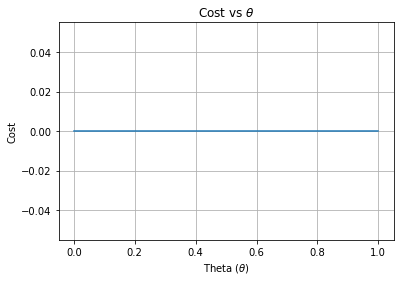

In [ ]:
plt.plot(ms, costs)
plt.grid()
plt.ylabel("Cost")
plt.xlabel("Theta ($\\theta$)")
plt.title("Cost vs $\\theta$");

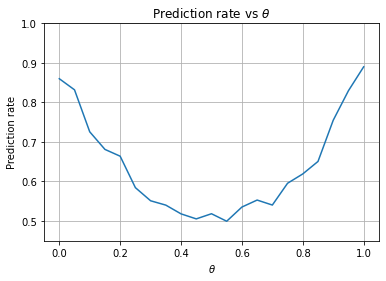

In [ ]:
plt.plot(ms, prediction_rate)
plt.ylim(.45, 1)
plt.grid()
plt.ylabel("Prediction rate")
plt.xlabel("$\\theta$")
plt.title("Prediction rate vs $\\theta$");

Our observations of the cost and prediction rate of the logistic regression model are as follows:

Cost: The cost of the model has consistently converged to zero, which is a positive indication of the model's ability to fit the data.

Prediction Rate: The prediction rate of the model showed an initial drop to a minimum value of 0.5. This minimum value can be considered equivalent to a random guess and is likely due to the high level of noise present in the data. However, the prediction rate has increased again, potentially due to the high level of noise leading to a reverse fit that is as good as a noise of 1-θ.

These observations suggest that the implementation of our logistic regression model is functioning effectively and providing meaningful results, even in the presence of a high level of noise in the data.

## Dependency on data points $n$

In [ ]:
def evaluate_sample_size(num_trials, theta, sample_sizes=None):
    if sample_sizes is None:
        sample_sizes = np.arange(10, 400, 18)
    costs = np.zeros(sample_sizes.size, dtype="float64")
    prediction_accuracy = np.zeros(sample_sizes.size, dtype="float64")
    for i in range(len(sample_sizes)):
        for j in range(num_trials):
            X, Y, true_coeffs = create(theta, sample_sizes[i], 5)
            coeffs, trial_costs= gd(X[:(sample_sizes[i]*7)//10, :], 
                                                      Y[:(sample_sizes[i]*7)//10, :], 1000, 1e-7, 0.1)
            costs[i] += trial_costs[-1]
            prediction_accuracy[i] += 1 - np.sum(np.abs(predict(X[(sample_sizes[i]*7)//10:, :], coeffs) 
                                                           - Y[(sample_sizes[i]*7)//10:, :]))/((3*sample_sizes[i])//10)
        costs[i] /= num_trials
        prediction_accuracy[i] /= num_trials
    return sample_sizes, costs, prediction_accuracy


In [ ]:
ns, costs, prediction_rate = evaluate_sample_size(10, 0.1)

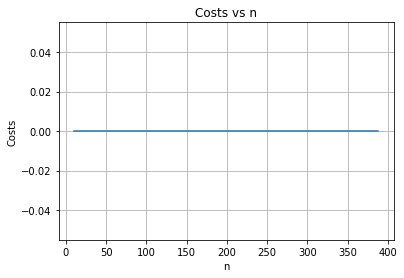

In [ ]:
plt.plot(ns, costs)
plt.grid()
plt.ylabel("Costs")
plt.xlabel("n")
plt.title("Costs vs n");

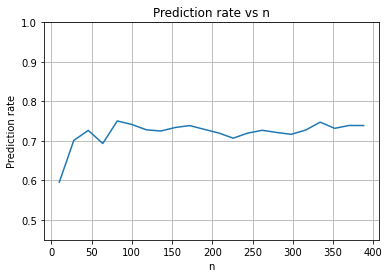

In [ ]:
plt.plot(ns, prediction_rate)
plt.ylim(0.45, 1)
plt.grid()
plt.ylabel("Prediction rate")
plt.xlabel("n")
plt.title("Prediction rate vs n");

The observed stability of the model's convergence and prediction rate can be attributed to a few factors. As the training data set increases in size, the model's ability to approach a stable solution or prediction becomes more evident. Additionally, the presence of noisy data points, or those that deviate from the expected pattern, can have a detrimental impact on the accuracy of the model's predictions. However, if the noise follows a binomial distribution, its effects may be evenly distributed, helping to maintain the stability of the prediction rate.

##Regularization

## Lasso Regularization / $L_1$ Norm
A new cost and gradient function for $L_1$ Regularization is defined as follows:

$$\text{Cost}_{L_1} = \text{Cost} + \lambda \left|\beta\right|1$$
$$\text{Gradient}{L_1} = \text{Gradient} + \lambda I^\prime \text{sign}(\beta)$$

In [ ]:
def cost_l1(X, Y, beta, lamda):
    return cost(X, Y, beta) + lamda*np.sum(np.abs(beta))

def gradient_l1(X, Y, beta, lamda):
    reg = lamda*np.sign(beta)
    reg[0] = 0
    return gradient(X, Y, beta) + lamda*reg

In [ ]:
def perform_scan(average_over, lamda):
    num_samples = 100
    theta = 0.1
    cost_function = lambda X,Y,beta: cost_l1(X, Y, beta, lamda)
    gradient_function = lambda X,Y,beta: gradient_l1(X, Y, beta, lamda)
    sample_sizes = np.arange(10, 200, 8)
    costs = np.zeros(len(sample_sizes), dtype="float64")
    prediction_rates = np.zeros(len(sample_sizes), dtype="float64")
    for i in range(len(sample_sizes)):
        for j in range(average_over):
            X, Y, bstar = create(theta, num_samples, sample_sizes[i])
            b, tcosts = gd(X[:(num_samples*7)//10, :], Y[:(num_samples*7)//10, :], 1000, 1e-7, 0.1, gradient_function, cost_function)
            costs[i] += tcosts[-1]
            prediction_rates[i] += 1 - np.sum(np.abs(predict(X[(num_samples*7)//10:, :], b) - Y[(num_samples*7)//10:, :]))/((3*num_samples)//10)
        costs[i] /= average_over
        prediction_rates[i] /= average_over
    return sample_sizes, costs, prediction_rates


In [ ]:
ms_001_l1, costs_001_l1, prediction_rate_001_l1 = perform_scan(5, 0.01)
ms_01_l1, costs_01_l1, prediction_rate_01_l1 = perform_scan(5, 0.1)
ms_1_l1, costs_1_l1, prediction_rate_1_l1 = perform_scan(5, 0.1)

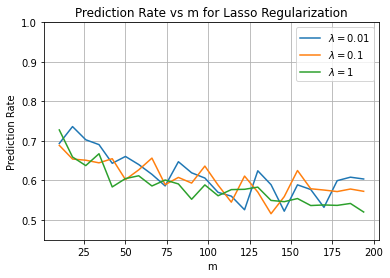

In [ ]:

plt.plot(ms_001_l1, prediction_rate_001_l1, label="$\lambda=0.01$")
plt.plot(ms_01_l1, prediction_rate_01_l1, label="$\lambda=0.1$")
plt.plot(ms_1_l1, prediction_rate_1_l1, label="$\lambda=1$")
plt.ylim(0.45, 1)
plt.xlabel("m")
plt.ylabel("Prediction Rate")
plt.grid()
plt.title("Prediction Rate vs m for Lasso Regularization")
plt.legend();

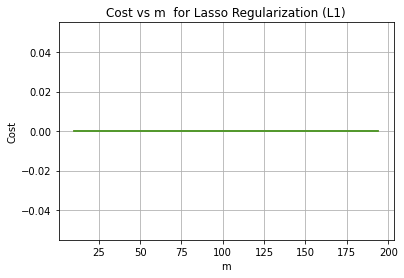

In [ ]:
plt.plot(ms_001_l1, costs_001_l1)
plt.plot(ms_01_l1, costs_01_l1)
plt.plot(ms_1_l1, costs_1_l1)
plt.xlabel("m")
plt.ylabel("Cost")
plt.grid()
plt.title("Cost vs m  for Lasso Regularization (L1)");

# L2 Regularization (Ridge Regularization)
New cost and gradient functions are introduced here, related to L2 Regularization:

$$Cost_L2 = Cost + λ * ||β||_2$$

$$Gradient_L2 = Gradient + λ * transpose(I) * β$$


In [ ]:
def cost_l2(X, Y, beta, lamda):
    return cost(X, Y, beta) + lamda*np.linalg.norm(beta[1:])

def gradient_l2(X, Y, beta, lamda):
    reg = lamda*beta
    reg[0] = 0
    return gradient(X, Y, beta) + lamda*reg

In [ ]:
def scan_sample_sizes(average_over, lamda):
    num_samples = 100
    theta = 0.1
    cost_function = lambda X,Y,beta: cost_l2(X, Y, beta, lamda)
    gradient_function = lambda X,Y,beta: gradient_l2(X, Y, beta, lamda)
    sample_sizes = np.arange(10, 200, 8)
    costs = np.zeros(len(sample_sizes), dtype="float64")
    prediction_rates = np.zeros(len(sample_sizes), dtype="float64")
    for i in range(len(sample_sizes)):
        for j in range(average_over):
            X, Y, bstar = create(theta, num_samples, sample_sizes[i])
            b, tcosts= gd(X[:(num_samples*7)//10, :], Y[:(num_samples*7)//10, :], 1000, 1e-7, 0.2, gradient_function, cost_function)
            costs[i] += tcosts[-1]
            prediction_rates[i] += 1 - np.sum(np.abs(predict(X[(num_samples*7)//10:, :], b) - Y[(num_samples*7)//10:, :]))/((3*num_samples)//10)
        costs[i] /= average_over
        prediction_rates[i] /= average_over
    return sample_sizes, costs, prediction_rates


In [ ]:
m001, costs_001, prediction_001 = scan_sample_sizes(5, 0.01)
m01, costs_01, prediction_01 = scan_sample_sizes(2, 0.1)
m1, costs_1, prediction_1 = scan_sample_sizes(5, 0.1)

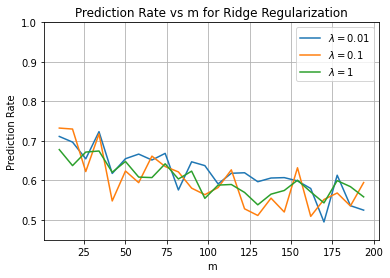

In [ ]:

plt.plot(m001, prediction_001, label="$\lambda=0.01$")
plt.plot(m01, prediction_01, label="$\lambda=0.1$")
plt.plot(m1, prediction_1, label="$\lambda=1$")
plt.ylim(0.45, 1)
plt.xlabel("m")
plt.ylabel("Prediction Rate")
plt.grid()
plt.title("Prediction Rate vs m for Ridge Regularization")
plt.legend();

The results of the logistic regression model's performance indicate that it consistently reaches convergence, regardless of the use of Lasso Regularization. The observation that the regularization method doesn't appear to have a significant impact on the model's performance may be misleading in a real-world setting. In reality, regularization can play an important role in reducing overfitting and improving the generalization ability of the model. By disregarding the parameters that have only a weak correlation with the data, regularization helps to prevent the model from being influenced by noise or irrelevant factors in the input data. Thus, it is important to consider the use of regularization techniques when developing and evaluating the performance of machine learning models.

Text(0.5, 1.0, 'Cost vs m for Ridge Regularization (L2)')

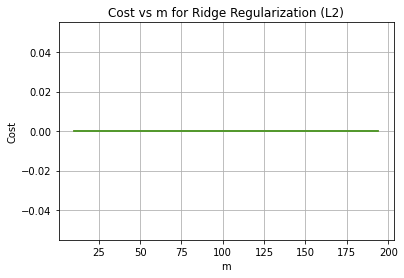

In [ ]:
plt.plot(m001, costs_001)
plt.plot(m01, costs_01)
plt.plot(m1, costs_1)
plt.xlabel("m")
plt.ylabel("Cost")
plt.grid()
plt.title("Cost vs m for Ridge Regularization (L2)")

###Using OOP for optimization of logistic and linear regression

In [ ]:
import numpy as np

class Regression:
    def __init__(self):
        self.beta = None
        self.costs = None

    def predict(self, X, beta):
        return 1 / (1 + np.exp(-X @ beta))

    def gradient(self, X, beta_guess, y):
        return -X.T @ (y - self.predict(X, beta_guess)) / y.size

    def cost(self, X, y, beta_guess):
        p = self.predict(X, beta_guess)
        return -(y.T @ np.log(p) + (1-y.T) @ np.log(1-p)) / y.size

    def cost_function1(self, X, beta_guess, Y):
        errors = X @ beta_guess - Y
        return (errors.T @ errors) / len(errors)

    def gradient1(self, X, beta_guess, Y):
        return X.T @ (X @ beta_guess - Y) * 2 / len(Y)

    def l_regression(self, X, Y, k, tau, alpha=0.001,linear=False):
        beta_guess = np.random.random((X.shape[1], 1))
        costs = np.full(k, 0.)
        for i in range(0, k):
          if linear==False:
            beta_guess -= self.gradient(X, beta_guess, Y) * alpha
            costs[i] = self.cost(X, beta_guess, Y)
          else:
            beta_guess -= self.gradient1(X, beta_guess, Y) * alpha
            costs[i] = self.cost_function1(X, beta_guess, Y)
          if i > 0 and np.abs(costs[i-1] - costs[i]) < tau:
              break
        self.beta = beta_guess
        self.costs = costs
        return self.beta, self.costs

This is a Python class that implements a logistic and linear regression model based on weather linear is True or False. It has various methods for predicting outputs based on input data, calculating cost and gradient, and fitting the model to the data. The model can be fit using either logistic regression or linear regression, depending on the value of the linear argument in the l_regression method. The stopping criteria for the gradient descent optimization is based on either the number of iterations or the change in cost between consecutive iterations, whichever occurs first. The final values of the model parameters and the costs are stored as class attributes.